In [326]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pgmpy as pgmpy
import seaborn as sns
from itertools import combinations, product
from pgmpy.models import NaiveBayes, BayesianModel, BayesianNetwork, MarkovModel, FactorGraph, JunctionTree
from pgmpy.inference import VariableElimination
from pgmpy.estimators import TreeSearch, ParameterEstimator, BayesianEstimator, MaximumLikelihoodEstimator, BayesianEstimator
from tabulate import tabulate as tab
import warnings

# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



IMPORT DATASET AND ANALISYS 

DATASET CONTAINS 299 rows and 13 columns

DATASET DESCRIPTION:


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000



DATASET BAR-GRAPH


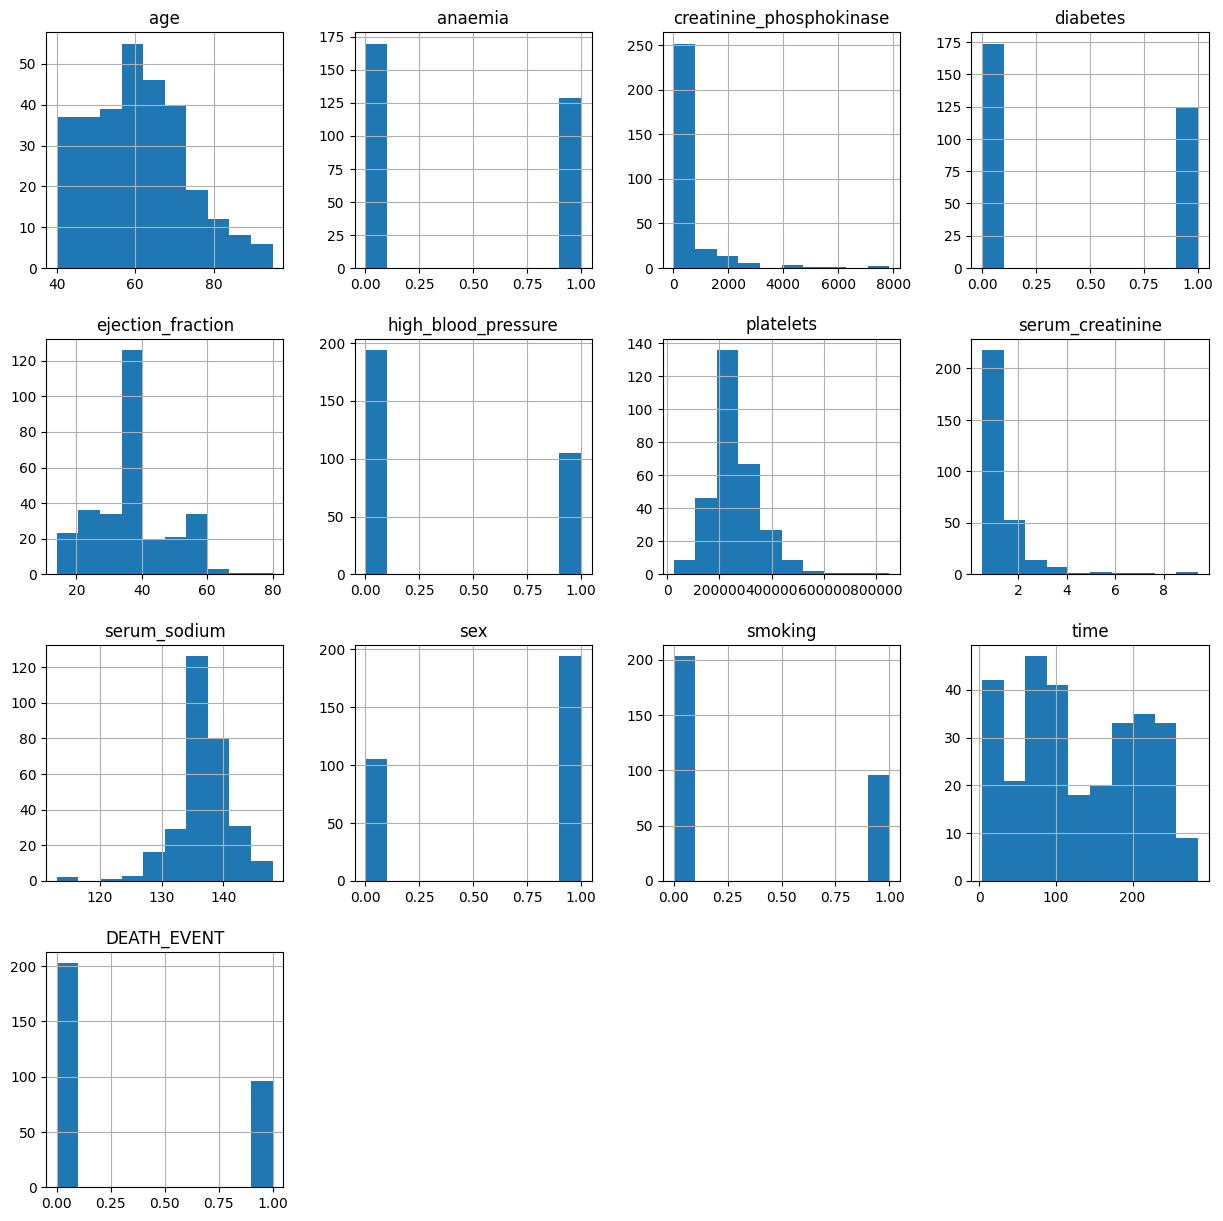

In [327]:
df = pd.read_csv('Dataset/heart_failure_clinical_records_dataset.csv')
print("DATASET CONTAINS {} rows and {} columns".format(df.shape[0], df.shape[1]))
print("\nDATASET DESCRIPTION:")
display(df.describe())
print("\nDATASET BAR-GRAPH")
df.hist(figsize = [15,15])
plt.show()

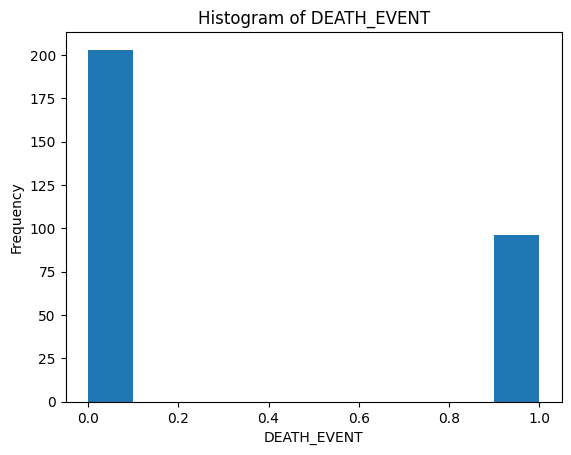

In [328]:
# Define the target variable
target = 'DEATH_EVENT'

# Plot histogram
plt.hist(df[target])
plt.title('Histogram of {}'.format(target))
plt.xlabel(target)
plt.ylabel('Frequency')

# Show the plot
plt.show()

# Inegrity Check

In [329]:
display(df.columns)
np.sum(pd.isnull(df), 0)



Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

# Data cleaning and classifing into dicrete interval

In [330]:
data = {}
dic =   { 
            'age':[0,50,60,75,95], 
            'creatinine_phosphokinase':[20,200,350,550,3000,8000], 
            'ejection_fraction': [0, 40, 50, 70, 100], 
            'platelets':[0, 160000, 370000, 850000],
            'serum_creatinine': [0, 0.48, 1.0, 1.5, 3.5, 9.5],
            'serum_sodium': [110, 135, 145, 150],
            'time': [0, 70, 160, 300]
        }

for key, val in dic.items():
    bin = pd.cut(df[key], val)
    interval = {x: i for i, x in enumerate(bin.dtype.categories)}
    data[key] = interval
    df[key] = bin.apply(lambda x: interval[x])


for col, map in data.items():
    print(col)
    table = tab(map.items(), headers=['Interval', 'Value'], tablefmt='fancy_grid')
    print(table, end='\n\n')

df.describe()


    

0      (60, 75]
1      (50, 60]
2      (60, 75]
3       (0, 50]
4      (60, 75]
         ...   
294    (60, 75]
295    (50, 60]
296     (0, 50]
297     (0, 50]
298     (0, 50]
Name: age, Length: 299, dtype: category
Categories (4, interval[int64, right]): [(0, 50] < (50, 60] < (60, 75] < (75, 95]]
{Interval(0, 50, closed='right'): 0, Interval(50, 60, closed='right'): 1, Interval(60, 75, closed='right'): 2, Interval(75, 95, closed='right'): 3}
0       (550, 3000]
1      (3000, 8000]
2         (20, 200]
3         (20, 200]
4         (20, 200]
           ...     
294       (20, 200]
295     (550, 3000]
296     (550, 3000]
297     (550, 3000]
298       (20, 200]
Name: creatinine_phosphokinase, Length: 299, dtype: category
Categories (5, interval[int64, right]): [(20, 200] < (200, 350] < (350, 550] < (550, 3000] < (3000, 8000]]
{Interval(20, 200, closed='right'): 0, Interval(200, 350, closed='right'): 1, Interval(350, 550, closed='right'): 2, Interval(550, 3000, closed='right'): 3, Interval

,anaemia,diabetes,high_blood_pressure,sex,smoking,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.00000,299.00000
mean,0.431438,0.418060,0.351171,0.648829,0.32107,0.32107
std,0.496107,0.494067,0.478136,0.478136,0.46767,0.46767
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
50%,0.000000,0.000000,0.000000,1.000000,0.00000,0.00000
75%,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000
max,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000


In [331]:
legenda = {
            'age':{0: '0-50', 1: '50-60', 2: '60-75', 3: '75-95'},
            'creatine_phosphokinase':{0: '0-20', 1: '20-200', 2: '200-350', 3: '350-550', 4: '550-3000', 5: '3000-8000'},
            'ejection_fraction':{0: '0-40', 1: '40-50', 2: '50-70', 3: '70-100'},
            'platelets':{0: '0-160000', 1: '160000-370000', 2: '370000-850000'},
            'serum_creatinine':{0: '0-0.48', 1: '0.48-1.0', 2: '1.0-1.5', 3: '1.5-3.5', 4: '3.5-9.5'},
            'serum_sodium':{0: '110-135', 1: '135-145', 2: '145-150'},
            'time':{0: '0-70', 1: '70-160', 2: '160-300'},
            'DEATH_EVENT':{0: 'Dead', 1: 'Alive'},
            'anaemia':{0: 'No', 1: 'Yes'},
            'diabetes':{0: 'No', 1: 'Yes'},
            'high_blood_pressure':{0: 'No', 1: 'Yes'},
            'sex':{0:'Female', 1:'Male'},
            'smoking':{0: 'Yes', 1: 'No'}
        }

legenda_reverse = {key: {v: k for k, v in val.items()} for key, val in legenda.items()}

itertools.combinations

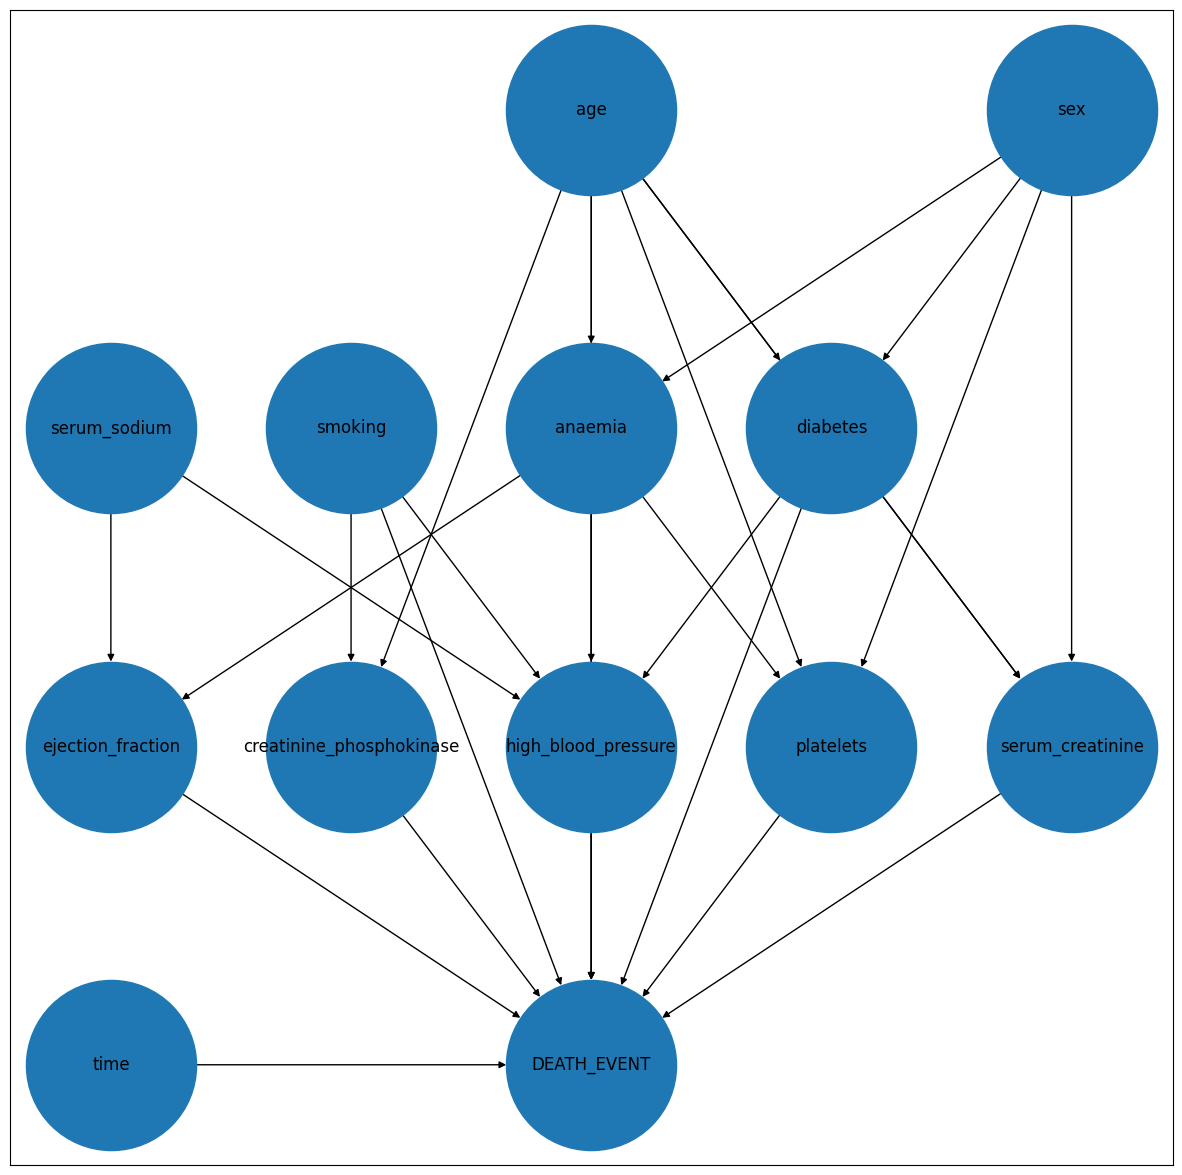

In [332]:
network = BayesianNetwork([
                    ('age','anaemia'), 
                    ('age', 'creatinine_phosphokinase'),
                    ('age', 'diabetes'),
                    ('age', 'platelets'),
                    ('age', 'serum_creatinine'),
                    ('age', 'DEATH_EVENT'),
                    ('sex','anaemia'),
                    ('sex', 'diabetes'),
                    ('sex', 'platelets'),
                    ('sex', 'serum_creatinine'),
                    ('anaemia', 'ejection_fraction'),
                    ('anaemia', 'high_blood_pressure'),
                    ('anaemia', 'platelets'),
                    ('anaemia', 'DEATH_EVENT'),
                    ('diabetes', 'high_blood_pressure'),
                    ('diabetes', 'serum_creatinine'),
                    ('diabetes', 'DEATH_EVENT'),
                    ('smoking', 'high_blood_pressure'),
                    ('smoking', 'creatinine_phosphokinase'),
                    ('smoking', 'DEATH_EVENT'),
                    ('serum_sodium', 'high_blood_pressure'),
                    ('serum_sodium', 'ejection_fraction'),
                    ('ejection_fraction', 'DEATH_EVENT'),
                    ('high_blood_pressure', 'DEATH_EVENT'),
                    ('serum_creatinine', 'DEATH_EVENT'),
                    ('creatinine_phosphokinase', 'DEATH_EVENT'),
                    ('platelets', 'DEATH_EVENT'), 
                    ('time', 'DEATH_EVENT')
                    ])

pos={
    'age':[0.75, -0.5], 'sex':[1.25, -0.5],
    'serum_sodium':[0.25, -1], 'smoking':[0.50, -1], 'anaemia':[0.75, -1], 'diabetes':[1, -1],
    'ejection_fraction':[0.25, -1.5], 'creatinine_phosphokinase':[0.50, -1.5], 'high_blood_pressure':[0.75, -1.5], 'platelets':[1, -1.5], 'serum_creatinine':[1.25, -1.5],
    'time':[0.25,-2], 'DEATH_EVENT':[0.75, -2]
    }

fig,ax = plt.subplots(1, 1, figsize=(15,15))
nx.draw_networkx(network, pos=pos, ax=ax, node_size=15000)


In [333]:
np.sum(pd.isnull(df), 0)


age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

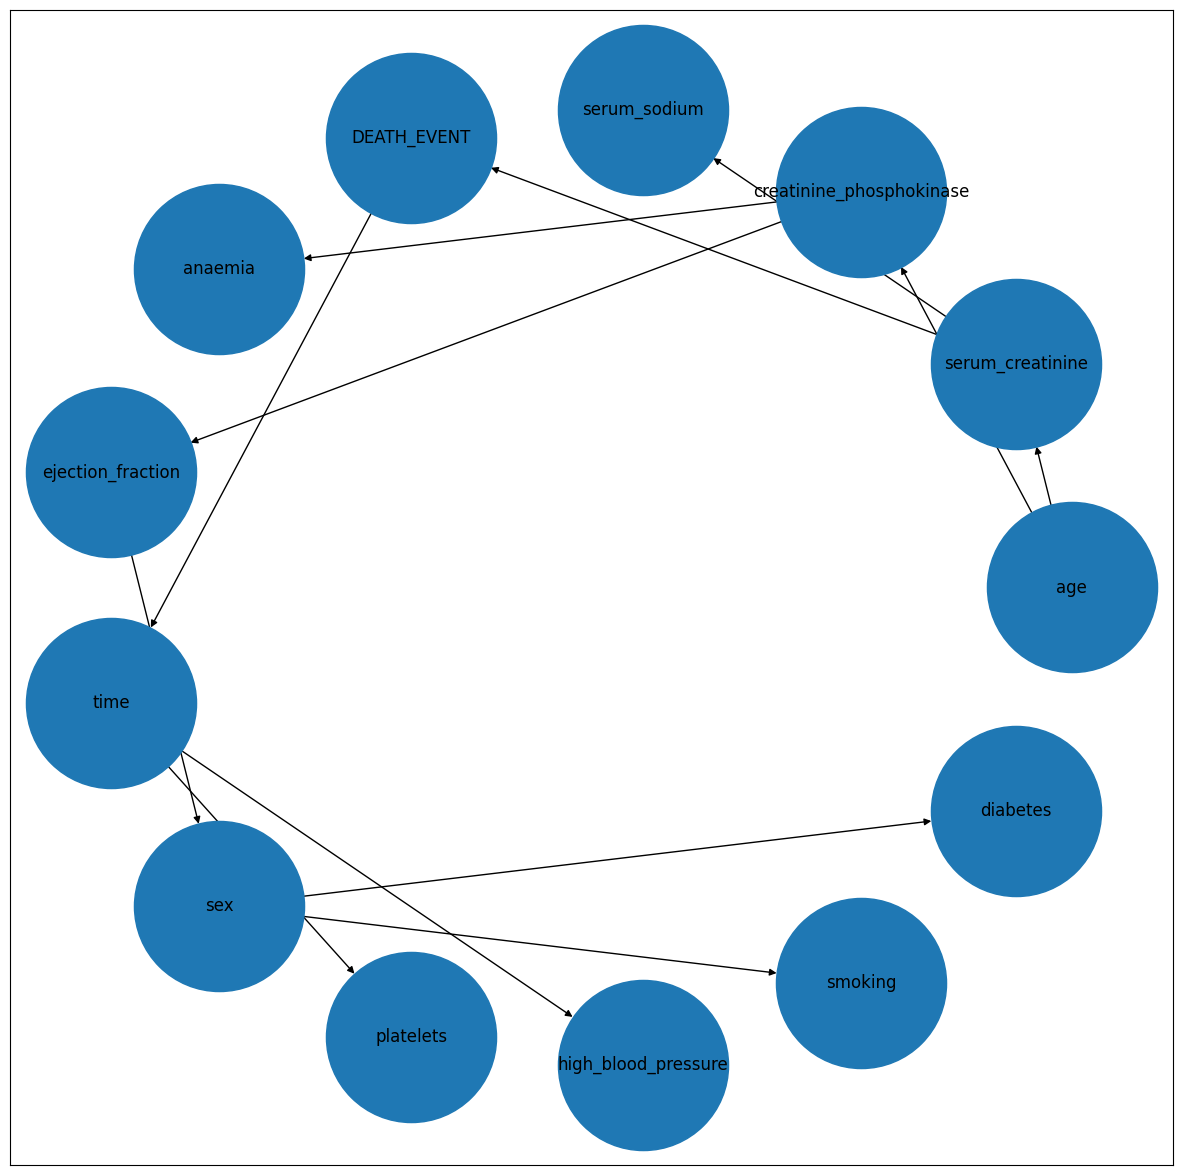

In [334]:
ts = TreeSearch(data=df, root_node='age')
tree_model = ts.estimate(show_progress=False) 

fig,ax = plt.subplots(1, 1, figsize=(15,15))
nx.draw_networkx(tree_model, pos=nx.drawing.layout.circular_layout(tree_model), ax=ax, node_size=15000)

In [335]:
network.fit(data=df, estimator=MaximumLikelihoodEstimator) 


#mle = MaximumLikelihoodEstimator(network, data=df)
#be = BayesianEstimator(network, data=df)
#for x in df.columns:
#    print(x)
#    print("Maximum Likelihood Estimator\n", mle.estimate_cpd(x))
#   print("Bayesian Estimator\n", be.estimate_cpd(x))



SIMPLIFY CPD? NOISY OR 

In [421]:
from pgmpy.factors.discrete import TabularCPD

def recursive_product_traspose(lists):
    if len(lists) == 1:
        return [[x] for x in lists[0]]
    else:
        result = []
        for value in lists[0]:
            sub_products = recursive_product_traspose(lists[1:])
            for product in sub_products:
                result.append([value] + product)
        return [list(row) for row in zip(*result)]

def noisyOr_tabular_estimator(parents: list, target : str, network=network):

    variable_card = network.get_cardinality(target)
    
    values = [list(np.mean(network.get_cpds(node).get_values(), axis=1)) for node in parents]

    res = recursive_product_traspose(values)

    parents_card = [network.get_cardinality(node) for node in parents]

    tabular = TabularCPD(target, variable_card, res, parents, parents_card)
    display(tabular)
    return tabular

# Creiamo la tabella di Noisy OR per il nodo 'diabetes'
cpd_diabetes_noisy_or = noisyOr_tabular_estimator(['age', 'sex'], 'diabetes')

# Stampa la tabella di Noisy OR per il nodo 'diabetes'
print(cpd_diabetes_noisy_or)


<TabularCPD representing P(diabetes:2 | age:4, sex:2) at 0x2b5e6e41b10>

+-------------+---------------------+-----+---------------------+
| age         | age(0)              | ... | age(3)              |
+-------------+---------------------+-----+---------------------+
| sex         | sex(0)              | ... | sex(1)              |
+-------------+---------------------+-----+---------------------+
| diabetes(0) | 0.24749163879598662 | ... | 0.10033444816053512 |
+-------------+---------------------+-----+---------------------+
| diabetes(1) | 0.3511705685618729  | ... | 0.6488294314381271  |
+-------------+---------------------+-----+---------------------+


In [338]:
print("Total number of valid indipendencies: ", len(network.get_independencies().get_assertions()))
for node in network.nodes():
    print("Local independencies: ", network.local_independencies(node))

Total number of valid indipendencies:  20080
Local independencies:  (age ⟂ time, serum_sodium, sex, smoking)
Local independencies:  (anaemia ⟂ serum_sodium, time, diabetes, smoking, serum_creatinine, creatinine_phosphokinase | age, sex)
Local independencies:  (creatinine_phosphokinase ⟂ serum_sodium, sex, ejection_fraction, serum_creatinine, anaemia, time, platelets, diabetes, high_blood_pressure | age, smoking)
Local independencies:  (diabetes ⟂ anaemia, serum_sodium, time, smoking, platelets, ejection_fraction, creatinine_phosphokinase | age, sex)
Local independencies:  (platelets ⟂ serum_sodium, ejection_fraction, serum_creatinine, time, smoking, diabetes, high_blood_pressure, creatinine_phosphokinase | anaemia, age, sex)
Local independencies:  (serum_creatinine ⟂ serum_sodium, ejection_fraction, anaemia, time, smoking, platelets, high_blood_pressure, creatinine_phosphokinase | age, sex, diabetes)
Local independencies:  (DEATH_EVENT ⟂ serum_sodium, sex | ejection_fraction, serum_cre

Performing inference

Question: Probability of Anaemia and Diabetes affects the probability of High Blood Pressure?

The function below is used to combine all possible values of the variables into a single dataframe

In [339]:
def cartesian_product(evidences):

    # Remove Given Evidence
    given = {key: value for key, value in evidences.items() if value is not None}
    combine = {key: value for key, value in evidences.items() if value is None}

    # Get values for each specified key
    values = [list(legenda_reverse[key]) for key in combine]
    # Calculate all combinations of values across specified keys
    combinations = list(product(*values))

    # Pairing keys with values
    combinations = [{key: value for key, value in zip(combine.keys(), combination)} for combination in combinations ]
    for combination in combinations:
        combination.update(given)

    # append given evidence to each combination
    return combinations

The function below is used to calculate the probability of a given query variable value given an evidence variable value. The function takes as input the query variable, the evidence variable, the evidence variable value, the Bayesian network. The function returns the probability of the query variable value given the evidence variable value.

In [340]:
def inference(evidences : dict, target : str, network=network, combinations=None):
    inferences = VariableElimination(network)
    res = {}
    
    if combinations is None:
        combinations = cartesian_product(evidences)
   
    for comb in combinations:
        evidence = {key: legenda_reverse[key][value] for key, value in comb.items()}

        q = inferences.query(variables=[target], evidence=evidence)
        res[','.join(comb.values())] = q.values
        
    return res

The function below is used to grph the probabilities of the variables using a bar plot

In [341]:
def plot_bar(data, title, evidences, target, fig_size=(50, 5)):
    dataFrame = pd.DataFrame([[str(x), legenda[target][bars], float(y)]
                 for x in data.keys()
                 for bars, y in enumerate(data[x])],
                 columns=[str(evidences), str(target), 'Probability'])

    fig, ax = plt.subplots(1, 1, figsize=fig_size)
    sns.barplot(x=str(evidences), y='Probability', hue=str(target), data=dataFrame, ax=ax, palette='dark')
    plt.title(title)
    plt.show()

Inferring the probability of serus creatinine given the probability of age, sex and serum sodium

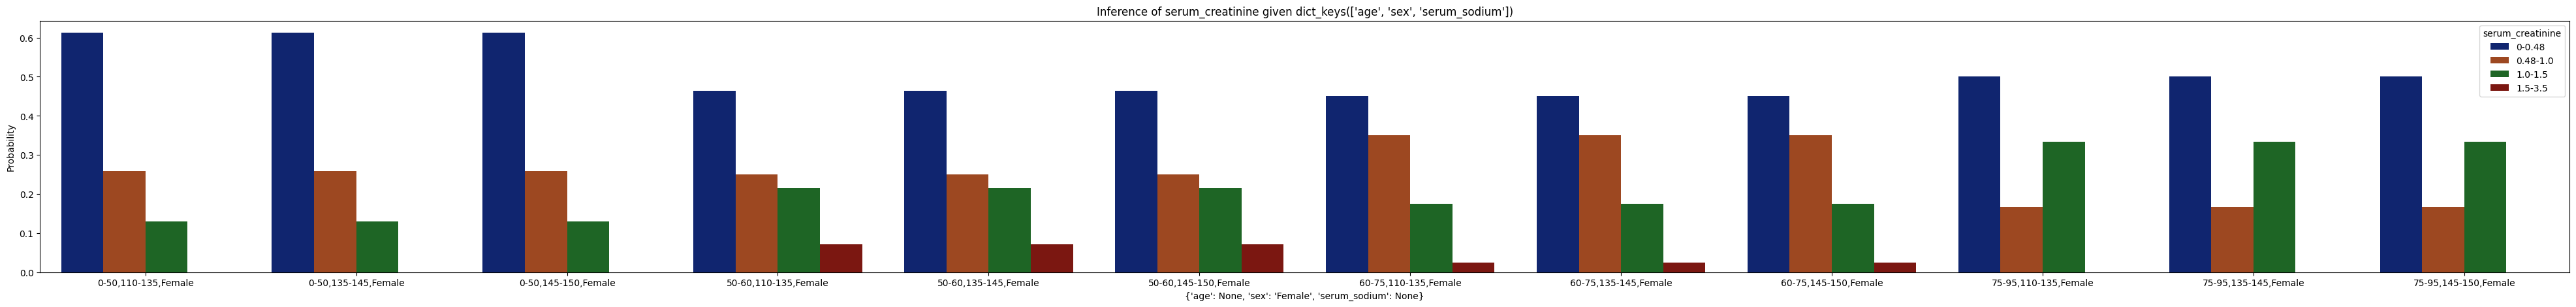

In [342]:
evidences = {'age':None,'sex':'Female', 'serum_sodium':None}
title = "Inference of serum_creatinine given {}".format(evidences.keys())

inf  = inference(evidences, 'serum_creatinine', network)
plot_bar(inf, title, evidences, 'serum_creatinine')

Inferring the probability of Heart failure of a 74 year old that smoke

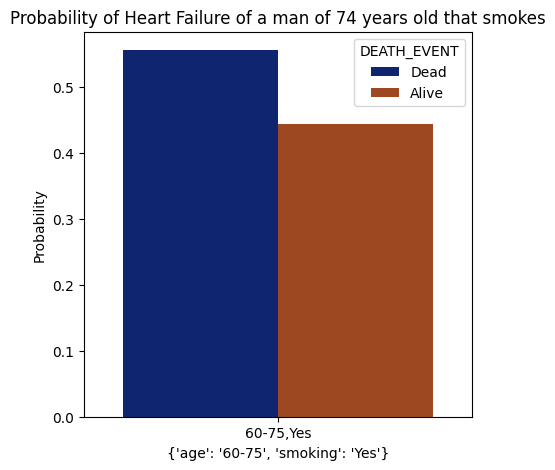

In [343]:
title='Probability of Heart Failure of a man of 74 years old that smokes'
evidence = {'age':'60-75', 'smoking':'Yes'}
target = 'DEATH_EVENT'

inf = inference(evidence, target, network)
plot_bar(inf, title, evidence, target, fig_size=(5, 5))




Markonv Blanket

In [344]:
#markov_blanket = set(inference.markov_blanket('serum_creatinine'))
print('Checking Markov blankets')
for node in network.nodes():
    print(f'The Markov blanket of node {node} is {network.get_markov_blanket(node)}')
print()

Checking Markov blankets
The Markov blanket of node age is ['sex', 'DEATH_EVENT', 'ejection_fraction', 'serum_creatinine', 'anaemia', 'time', 'smoking', 'platelets', 'diabetes', 'high_blood_pressure', 'creatinine_phosphokinase']
The Markov blanket of node anaemia is ['serum_sodium', 'sex', 'DEATH_EVENT', 'ejection_fraction', 'serum_creatinine', 'time', 'diabetes', 'smoking', 'platelets', 'age', 'high_blood_pressure', 'creatinine_phosphokinase']
The Markov blanket of node creatinine_phosphokinase is ['DEATH_EVENT', 'ejection_fraction', 'serum_creatinine', 'anaemia', 'time', 'smoking', 'platelets', 'age', 'diabetes', 'high_blood_pressure']
The Markov blanket of node diabetes is ['serum_sodium', 'sex', 'DEATH_EVENT', 'ejection_fraction', 'serum_creatinine', 'anaemia', 'time', 'smoking', 'platelets', 'age', 'high_blood_pressure', 'creatinine_phosphokinase']
The Markov blanket of node platelets is ['sex', 'DEATH_EVENT', 'ejection_fraction', 'serum_creatinine', 'anaemia', 'time', 'smoking', 

In [345]:
markov_blanket = set(network.get_markov_blanket('serum_sodium'))
print(f"Feature rilevanti per il nodo '{'serum_sodium'}': {markov_blanket}")

Feature rilevanti per il nodo 'serum_sodium': {'ejection_fraction', 'anaemia', 'diabetes', 'smoking', 'high_blood_pressure'}


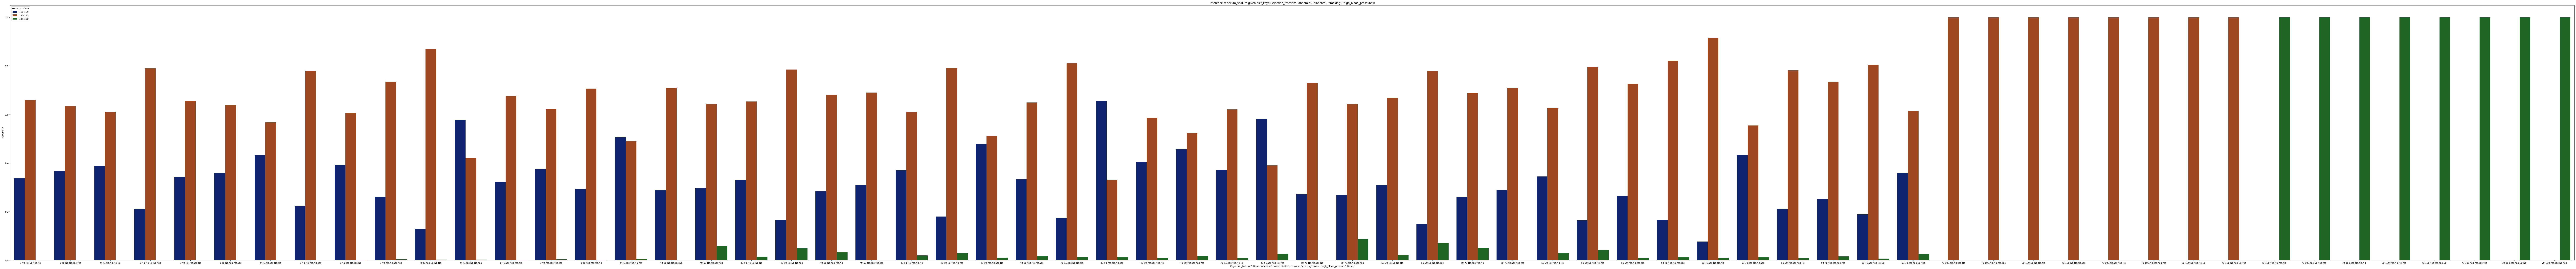

In [346]:
evidences = {key: None for key in markov_blanket}

inf = inference(evidences, 'serum_sodium', network)
plot_bar(inf, 'Inference of serum_sodium given {}'.format(evidences.keys()), evidences, 'serum_sodium', fig_size=(200, 20))